<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-data-and-EDA" data-toc-modified-id="Loading-data-and-EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading data and EDA</a></span></li><li><span><a href="#User-functions" data-toc-modified-id="User-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>User functions</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span><ul class="toc-item"><li><span><a href="#Layers-num" data-toc-modified-id="Layers-num-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Layers num</a></span></li><li><span><a href="#Neurons-number-and-activation-fx" data-toc-modified-id="Neurons-number-and-activation-fx-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Neurons number and activation fx</a></span></li><li><span><a href="#Dropout" data-toc-modified-id="Dropout-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Dropout</a></span></li><li><span><a href="#Batch-Size" data-toc-modified-id="Batch-Size-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Batch Size</a></span></li><li><span><a href="#Optimizer-testing" data-toc-modified-id="Optimizer-testing-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Optimizer testing</a></span></li></ul></li><li><span><a href="#Обучение-финальной-модели-и-валидация-на-тестовой-выборке" data-toc-modified-id="Обучение-финальной-модели-и-валидация-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение финальной модели и валидация на тестовой выборке</a></span></li></ul></div>

In [57]:
# 1. Basic Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import itertools
import warnings
import time
from pprint import pprint
import seaborn as sns

from tensorflow import keras as keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import warnings

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.metrics import r2_score

%matplotlib inline
warnings.filterwarnings('ignore')

#### Loading data and EDA

In [6]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

X_train.shape, y_train.shape, X_test.shape

((404, 13), (404,), (102, 13))

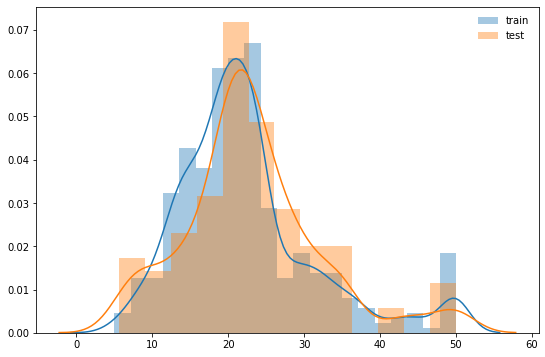

In [14]:
# 1.1. Target KDE
fig = plt.figure(figsize=(9,6))
sns.distplot(y_train, label='train')
sns.distplot(y_test, label='test')
plt.legend(frameon=False)
plt.show()

В целом распределения относительно симметричны (детальные тесты на нормальность не проводил)  
Существенной разницы между train и test не наблюдается

In [16]:
# 1.2. Features types and NANs
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

display(X_train_df.info())
display(X_test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 13 columns):
0     404 non-null float64
1     404 non-null float64
2     404 non-null float64
3     404 non-null float64
4     404 non-null float64
5     404 non-null float64
6     404 non-null float64
7     404 non-null float64
8     404 non-null float64
9     404 non-null float64
10    404 non-null float64
11    404 non-null float64
12    404 non-null float64
dtypes: float64(13)
memory usage: 41.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 13 columns):
0     102 non-null float64
1     102 non-null float64
2     102 non-null float64
3     102 non-null float64
4     102 non-null float64
5     102 non-null float64
6     102 non-null float64
7     102 non-null float64
8     102 non-null float64
9     102 non-null float64
10    102 non-null float64
11    102 non-null float64
12    102 non-null float64
dtypes: float64(13)
memory usage: 10.5 KB


None

In [17]:
display(X_train_df.describe())
display(X_test_df.describe())

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.00000
mean,3.092336,10.901961,11.264902,0.098039,0.544156,6.354157,66.849020,4.011982,9.980392,417.500000,18.374510,364.163333,12.30549
std,5.373088,21.572929,7.084148,0.298836,0.110015,0.672335,29.034993,2.379973,8.772121,177.390477,2.026785,79.138325,6.69540
min,0.013110,0.000000,1.220000,0.000000,0.392000,4.880000,6.000000,1.465500,1.000000,187.000000,13.000000,24.650000,1.92000
25%,0.084840,0.000000,5.455000,0.000000,0.445500,5.966000,42.450000,2.117375,4.000000,279.250000,17.400000,377.692500,7.30500
50%,0.229015,0.000000,9.795000,0.000000,0.532000,6.229000,73.750000,3.324850,5.000000,330.000000,18.900000,392.110000,11.06000
75%,3.779445,16.250000,18.100000,0.000000,0.609000,6.633750,92.975000,5.276650,24.000000,666.000000,20.200000,396.780000,15.91500
max,25.046100,90.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,21.200000,396.900000,31.99000


Пропусков нет, однако 3-й признак похож на бинарный, 8 - на категориальный

In [23]:
# 1.3. Проверка категориальности признаков
print('feature 3')
display(X_train_df[3].value_counts())
display(X_test_df[3].value_counts())
print(30*'-')
print('feature 8')
display(X_train_df[8].value_counts())
display(X_test_df[8].value_counts())

feature 3


0.0    379
1.0     25
Name: 3, dtype: int64

0.0    92
1.0    10
Name: 3, dtype: int64

------------------------------
feature 8


24.0    104
5.0      92
4.0      89
3.0      31
2.0      21
8.0      20
6.0      20
1.0      17
7.0      10
Name: 8, dtype: int64

24.0    28
5.0     23
4.0     21
7.0      7
3.0      7
6.0      6
8.0      4
1.0      3
2.0      3
Name: 8, dtype: int64

In [32]:
# 1.4. Преобразование признаков

#X_train_df[[3,8]] = X_train_df[[3,8]].astype('category')
#X_test_df[[3,8]] = X_test_df[[3,8]].astype('category')

X_train_df = pd.get_dummies(X_train_df, drop_first=True)
X_test_df = pd.get_dummies(X_test_df, drop_first=True)

print(set(X_train_df.columns.tolist()) - set(X_test_df.columns.tolist())) # check

set()


{'4-2': 0.7741996063949129,
 '2-4': 0.7741996063949129,
 '7-4': -0.7770621279671119,
 '7-6': -0.7666699665648696,
 '4-7': -0.7770621279671119,
 '6-7': -0.7666699665648696,
 '8_24.0-9': 0.921616325345293,
 '9-8_24.0': 0.921616325345293}

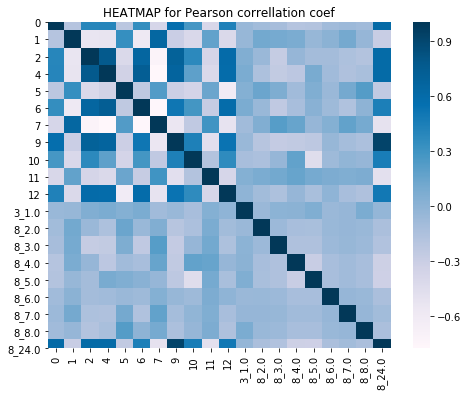

In [35]:
# 1.5. Corellation check

def plot_corr_map(corr_matrix):
    "plot given correlation matrix in heatmap style"
    fig = plt.figure(figsize=(8,6))
    ax = plt.axes()
    ax.set_title('HEATMAP for Pearson correllation coef')
    sns.heatmap(corr_matrix, square=True,ax=ax,cmap='PuBu');

# 2.4.2. Корелляция непрерывных данных
#corr_matrix = X_train_df.corr()
#plot_corr_map(corr_matrix)

# 3.5.3. Корелляция всех признаков
corr_matrix = X_train_df.corr()
plot_corr_map(corr_matrix)

correlated_features = dict()
corr_threshold = 0.75

for col in corr_matrix.columns:
    for row in corr_matrix[col].index:
        if corr_threshold < abs(corr_matrix.loc[row, col]) < 1.0:
            pair = f'{row}-{col}'
            correlated_features[pair] = corr_matrix.loc[row, col]

display(correlated_features)

Существует 4 пары признаков, корелляционно связанных. Однако вследствие того, что для обучения будет использоваться в общем случае нелинейная модель (ИНС), а также за счет регуляризации (Dropout) - удаляться данные признаки здесь не будут.  
Далее будет проверены главные компоненты и кластерный анализ

In [40]:
# 1.6. Data Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_df)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns=X_train_df.columns)

X_test_scaled = scaler.transform(X_test_df)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns=X_test_df.columns)

In [42]:
# 1.7. PCA check
from sklearn.decomposition import PCA
break_even = [0.8, 0.9, 0.95, 0.975, 0.99]

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
var_vector = np.cumsum(pca.explained_variance_ratio_)

for level in break_even:
    temp_list = []
    for n in var_vector:
        if n<=level: temp_list.append(n)
    print(f'required number of components for {level*100}% of total VAR is {len(temp_list)}')  

required number of components for 80.0% of total VAR is 6
required number of components for 90.0% of total VAR is 9
required number of components for 95.0% of total VAR is 12
required number of components for 97.5% of total VAR is 14
required number of components for 99.0% of total VAR is 17


Исходя из выводов РСА - удаление 3 признаков сохраняет 99% вариации, что соответствует выводам корелляции. 
Вследствие того, что в целом пространство признаков небольшое, преобразование далее осуществляться не будет

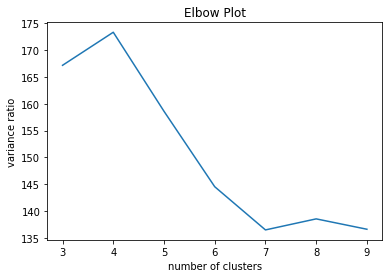

Silhouette Score for 3 clusters is 0.4188


In [45]:
# 1.8. KNN check

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

n_cluster_list, calinski_metric_list = [], []

for n_cluster in range(3,10):
    n_cluster_list.append(n_cluster)
    k_means = KMeans(n_clusters=n_cluster, random_state=37, init='k-means++', n_jobs=-1)
    k_means.fit(X_train_scaled)
    calinski_metric_list.append(calinski_harabasz_score(X_train_scaled, k_means.labels_))
    
plt.plot(n_cluster_list, calinski_metric_list)
plt.xlabel('number of clusters')
plt.ylabel('variance ratio')
plt.title('Elbow Plot')
plt.show()

k_means_optimal = KMeans(n_clusters=4, random_state=37, init='k-means++', n_jobs=-1)
k_means_optimal.fit(X_train_scaled)
silhouette_avg = silhouette_score(X_train_scaled, k_means.labels_)
print(f'Silhouette Score for 3 clusters is {round(silhouette_avg,5)}')


Оптимальное количество кластеров = 4, однако метрика Silhouette Score (=0.41) - далека от 1, поэтому генерация производных признаков на основе кластеров осуществляться не будет

In [47]:
# 1.9. Final Data Preparation for train and test
X_train_nn = X_train_scaled.to_numpy()
X_test_nn = X_test_scaled.to_numpy()

X_train.shape, X_train_nn.shape, X_test.shape, X_test_nn.shape, 

((404, 13), (404, 20), (102, 13), (102, 20))

#### User functions

Для простоты подбора параметров введены несколько декорирующих функций
- full_dense_regressor_compiler - компилирует модель с произвольным кол-вом слоев
- mlp_fit_valid - обучает и возвращает обученную модель
- mlp_predict - производит прогноз на тестовой выборке (c опцией переобучения на всей тренировочной выборке)
- r2 - рассчитывает r score

In [160]:
# 2.1. Функции
from tensorflow.keras.models import Model

def full_dense_regressor_compiler(layers_list, compile_params,  display_model=True, func_style=True):
    compile_params_keys = list(compile_params.keys())
    
    if len( set(compile_params_keys) - set(['optimizer', 'loss', 'metrics']) ) > 0:
        raise KeyError('incorrect compile params name')
    
    model = Sequential()
    
    if not func_style:
        for layer in layers_list:
            model.add(layer)
    else:
        model = Model(layers_list[0], layers_list[-1])
    
    optimizer = compile_params['optimizer']
    loss = compile_params['loss']
    metrics = compile_params['metrics']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    if display_model:
        model.summary()

    return model

# в качестве одной из метрик будет использоваться R2
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def mlp_regr_fit_valid(model, X , y, n_epochs=10, batch_size=32, 
                      validation_split=0.15, use_early_stopping=False, verbose_mode=0, show_chart=True):
    
    if use_early_stopping:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=0.15*n_epochs)
        callbacks = [es]
    else:
        callbacks = None
    
    start_time = time.time()
    history = model.fit(x=X, y=y, epochs=n_epochs, batch_size=batch_size, 
                        validation_split=validation_split, shuffle=True, verbose=verbose_mode,
                        callbacks=callbacks)
    
    if show_chart:
        fig = plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='valid')
        plt.legend()
        plt.show()
    
    best_idx = np.array(history.history['val_loss']).argmin()
    optimal_epoch_number = history.epoch[best_idx] + 1
    
    best_val_mape = history.history['val_mean_absolute_percentage_error'][best_idx]
    best_val_r2 = history.history['val_r2'][best_idx]
    
    best_val_loss = history.history['val_loss'][best_idx]
    best_tr_mape = history.history['mean_absolute_percentage_error'][best_idx]
    best_tr_r2 = history.history['r2'][best_idx]
    
    
    print(f'optimal epoch number: {optimal_epoch_number}')
    print('params on optimal epoch:')
    print(f'mape on valid: {best_val_mape:.4f}, on train: {best_tr_mape:.4f}')
    print(f'r2 on valid: {best_val_r2:.4f}, on train: {best_tr_r2:.4f}')
    print(f'best val loss: {best_val_loss}')
    print(f'refit finished in {(time.time()-start_time):1f} sec')
          
    return model

def mlp_predict(model, X_train_nn, y_train, X_test_nn, y_test, n_epochs=10, 
                batch_size=32, refit_model_on_full_data=True, verbose_refit=0):
    
    if refit_model_on_full_data:
        start_time = time.time()
        print('refit on full train (99%) dataset activated')
        model.fit(x=X_train_nn, y=y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.01,
                 verbose=verbose_refit)
        print(f'refit succeed in {(time.time()-start_time):.1f} sec')
        print()
    
    start_time = time.time()
    predict = model.predict(X_test_nn)
    print(f'predict generated in {(time.time()-start_time):.1f} sec')
    print(f'r2 on test dataset: {r2_score(y_test, predict):.4f}')   
        
    return predict

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_25 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 6         
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________


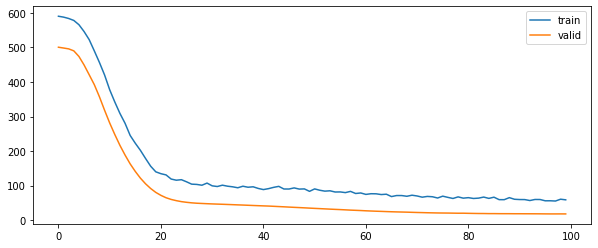

optimal epoch number: 100
params on optimal epoch:
mape on valid: 16.9134, on train: 24.9379
r2 on valid: 0.6177, on train: 0.2808
best val loss: 17.802960279511243
refit finished in 3.827967 sec
refit on full train (99%) dataset activated
refit succeed in 2.9 sec

predict generated in 0.0 sec
r2 on test dataset: 0.6797


In [110]:
# 2.2. Тестовый прогон функций

x_input = keras.layers.Input(shape=(20))
x_2 = keras.layers.Dense(20, activation='sigmoid')
x_3 = keras.layers.Dropout(0.2)
x_4 = keras.layers.Dense(5, activation='relu')
x_out = keras.layers.Dense(1, activation='linear')

sequence = [x_input, x_2, x_3, x_4, x_out]

comp_params = {
    'loss': 'mse',
    'optimizer': 'adam',
    'metrics': ['mean_absolute_percentage_error', r2]
}


model = full_dense_regressor_compiler(sequence, comp_params,  display_model=True, func_style=False)

model = mlp_regr_fit_valid(model, X_train_nn , y_train, n_epochs=100, batch_size=32, 
                      validation_split=0.1, use_early_stopping=False, verbose_mode=0, show_chart=True)

pred = mlp_predict(model, X_train_nn, y_train, X_test_nn, y_test, n_epochs=100, batch_size=32, 
                   refit_model_on_full_data=True, verbose_refit=0)

#### Подбор гиперпараметров

- я буду использовать early stopping callback с 15% долей

- поиск будет вестись с последовательным сужением пространства гиперпараметров
  
  - поиск оптимальной архитектуры (без учета Dropout), c использованием Relu и с небольшим числом нодов (32)
    - 1 слой
    - 2 слоя
    - 3 слоя
  - количество нодов
  - выбор оптимальной активационной функции
  - добавление dropout
  - выбор batch size
  - вариация алгоритмов оптимизации

In [102]:
# 3.1. basic params

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, SGD

input_shape = (20)

comp_params = {
    'loss': 'mse',
    'optimizer': 'adam',
    'metrics': ['mean_absolute_percentage_error', r2]
}

##### Layers num

1-hidden layer
--------------------------------------------------------------------------------
Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_118 (InputLayer)       [(None, 20)]              0         
_________________________________________________________________
dense_345 (Dense)            (None, 40)                840       
_________________________________________________________________
dense_346 (Dense)            (None, 1)                 41        
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


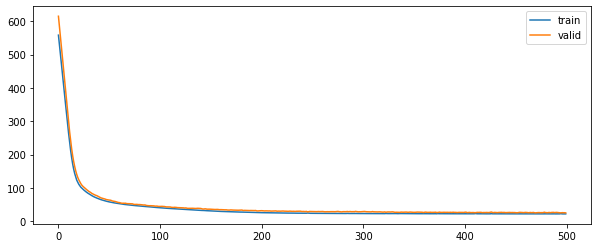

optimal epoch number: 500
params on optimal epoch:
mape on valid: 16.9469, on train: 17.0250
r2 on valid: 0.5571, on train: 0.7099
best val loss: 25.21659446056978
refit finished in 15.828778 sec
********************************************************************************
2-hidden layer
--------------------------------------------------------------------------------
Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_119 (InputLayer)       [(None, 20)]              0         
_________________________________________________________________
dense_347 (Dense)            (None, 40)                840       
_________________________________________________________________
dense_348 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_349 (Dense)            (None, 1)                 21        
Total params: 1

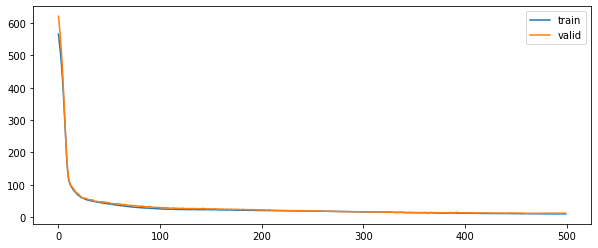

optimal epoch number: 466
params on optimal epoch:
mape on valid: 11.1559, on train: 11.2850
r2 on valid: 0.8193, on train: 0.8740
best val loss: 11.684235360887316
refit finished in 16.927752 sec
********************************************************************************
3-hidden layer
--------------------------------------------------------------------------------
Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_120 (InputLayer)       [(None, 20)]              0         
_________________________________________________________________
dense_350 (Dense)            (None, 40)                840       
_________________________________________________________________
dense_351 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_352 (Dense)            (None, 20)                620       
______________

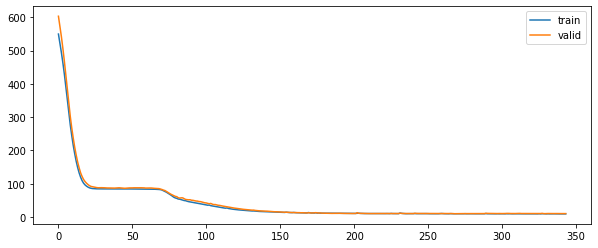

optimal epoch number: 269
params on optimal epoch:
mape on valid: 11.1022, on train: 11.6950
r2 on valid: 0.8402, on train: 0.7679
best val loss: 9.856558081544476
refit finished in 12.721210 sec
********************************************************************************
4-hidden layer
--------------------------------------------------------------------------------
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       [(None, 20)]              0         
_________________________________________________________________
dense_354 (Dense)            (None, 40)                840       
_________________________________________________________________
dense_355 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_356 (Dense)            (None, 20)                620       
_______________

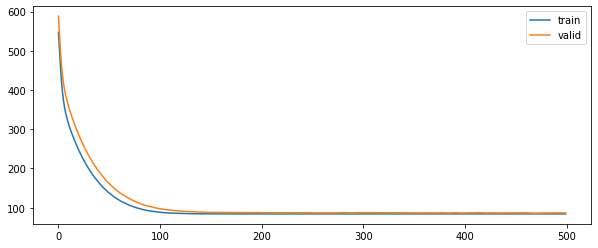

optimal epoch number: 475
params on optimal epoch:
mape on valid: 29.6359, on train: 36.8937
r2 on valid: -0.1073, on train: -0.1583
best val loss: 86.24638950677566
refit finished in 18.786058 sec
********************************************************************************


In [141]:
# 4.1.1. Подбор количества слоев

# 1-layer case
x_in = Input(input_shape)
x_1 = Dense(40, activation='linear')(x_in)
x_out = Dense(1, activation='linear')(x_1)
layers_seq1 = [x_in, x_1, x_out] 

print('1-hidden layer')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq1, compile_params=comp_params, display_model=True,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')


# 2-layer case
x_in = Input(input_shape)
x_1 = Dense(40, activation='linear')(x_in)
x_2 = Dense(20, activation='relu')(x_1)
x_out = Dense(1, activation='linear')(x_2)
layers_seq2 = [x_in, x_1, x_2, x_out] 

print('2-hidden layer')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq2, compile_params=comp_params, display_model=True,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')


# 3-layer case
x_in = Input(input_shape)
x_1 = Dense(40, activation='linear')(x_in)
x_2 = Dense(30, activation='sigmoid')(x_1)
x_3 = Dense(20, activation='relu')(x_2)
x_out = Dense(1, activation='linear')(x_3)
layers_seq3 = [x_in, x_1, x_2, x_3, x_out] 

print('3-hidden layer')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq3, compile_params=comp_params, display_model=True,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')


# 4-layer case
x_in = Input(input_shape)
x_1 = Dense(40, activation='linear')(x_in)
x_2 = Dense(30, activation='sigmoid')(x_1)
x_3 = Dense(20, activation='relu')(x_2)
x_4 = Dense(20, activation='tanh')(x_3)
x_out = Dense(1, activation='linear')(x_4)
layers_seq4 = [x_in, x_1, x_2, x_3, x_4, x_out] 

print('4-hidden layer')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq4, compile_params=comp_params, display_model=True,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')

Наилучшие показатели у сети с двумя и тремя скрытыми слоями, возьмем наиболее простой вариант (2 слоя)

##### Neurons number and activation fx

2-hidden layer: 20-20, Relu
--------------------------------------------------------------------------------


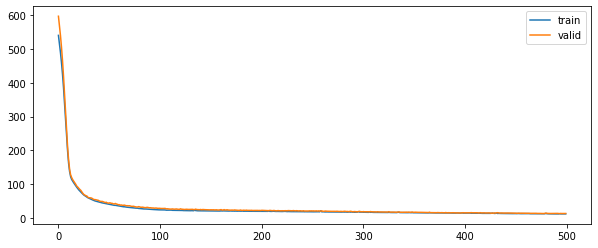

optimal epoch number: 494
params on optimal epoch:
mape on valid: 12.7144, on train: 13.7817
r2 on valid: 0.7737, on train: 0.8271
best val loss: 13.408619539237316
refit finished in 16.878953 sec
********************************************************************************
2-hidden layer: 20-20, Sigmoid
--------------------------------------------------------------------------------


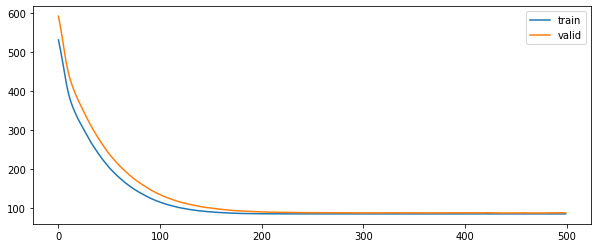

optimal epoch number: 450
params on optimal epoch:
mape on valid: 29.5790, on train: 36.7877
r2 on valid: -0.1068, on train: -0.0811
best val loss: 86.34287054744767
refit finished in 16.788211 sec
********************************************************************************
2-hidden layer: 128-128, Relu
--------------------------------------------------------------------------------
Epoch 00228: early stopping


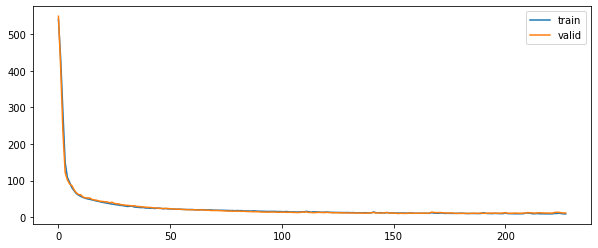

optimal epoch number: 153
params on optimal epoch:
mape on valid: 11.4259, on train: 11.7258
r2 on valid: 0.8272, on train: 0.7717
best val loss: 9.963257977991928
refit finished in 9.409622 sec
********************************************************************************
2-hidden layer: 128-128, Sigmoid
--------------------------------------------------------------------------------


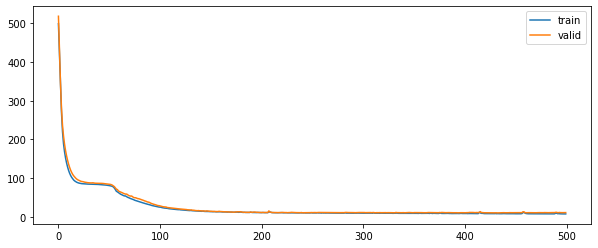

optimal epoch number: 433
params on optimal epoch:
mape on valid: 10.7601, on train: 10.4124
r2 on valid: 0.8439, on train: 0.8874
best val loss: 9.757442203568823
refit finished in 19.562977 sec
********************************************************************************
2-hidden layer: 256-128, Sigmoid
--------------------------------------------------------------------------------
Epoch 00381: early stopping


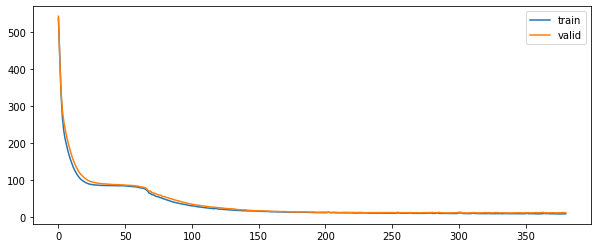

optimal epoch number: 306
params on optimal epoch:
mape on valid: 10.6227, on train: 10.9261
r2 on valid: 0.8406, on train: 0.8862
best val loss: 9.942614249241204
refit finished in 16.823321 sec
********************************************************************************
2-hidden layer: 256-256, Sigmoid
--------------------------------------------------------------------------------
Epoch 00251: early stopping


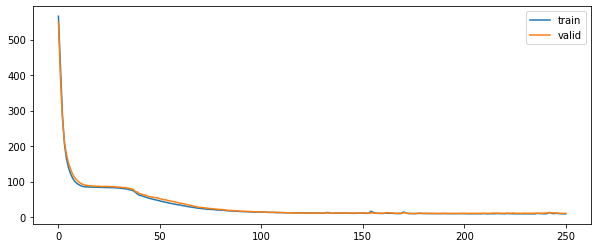

optimal epoch number: 176
params on optimal epoch:
mape on valid: 10.5848, on train: 11.9509
r2 on valid: 0.8401, on train: 0.8698
best val loss: 10.00419631416415
refit finished in 12.054582 sec
********************************************************************************


In [142]:
# 3.2.1. Подбор количества нейронов и вариация актив.функции

# вариант 1
x_in = Input(input_shape)
x_1 = Dense(20, activation='linear')(x_in)
x_2 = Dense(20, activation='relu')(x_1)
x_out = Dense(1, activation='linear')(x_2)
layers_seq1 = [x_in, x_1, x_2, x_out] 

print('2-hidden layer: 20-20, Relu')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq1, compile_params=comp_params, display_model=False,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')


# вариант 2
x_in = Input(input_shape)
x_1 = Dense(20, activation='linear')(x_in)
x_2 = Dense(20, activation='sigmoid')(x_1)
x_out = Dense(1, activation='linear')(x_2)
layers_seq2 = [x_in, x_1, x_2, x_out] 

print('2-hidden layer: 20-20, Sigmoid')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq2, compile_params=comp_params, display_model=False,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')



# вариант 3
x_in = Input(input_shape)
x_1 = Dense(128, activation='linear')(x_in)
x_2 = Dense(128, activation='relu')(x_1)
x_out = Dense(1, activation='linear')(x_2)
layers_seq3 = [x_in, x_1, x_2, x_out] 

print('2-hidden layer: 128-128, Relu')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq3, compile_params=comp_params, display_model=False,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')



# вариант 4
x_in = Input(input_shape)
x_1 = Dense(128, activation='linear')(x_in)
x_2 = Dense(128, activation='sigmoid')(x_1)
x_out = Dense(1, activation='linear')(x_2)
layers_seq4 = [x_in, x_1, x_2, x_out] 

print('2-hidden layer: 128-128, Sigmoid')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq4, compile_params=comp_params, display_model=False,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')


# вариант 5
x_in = Input(input_shape)
x_1 = Dense(256, activation='linear')(x_in)
x_2 = Dense(128, activation='sigmoid')(x_1)
x_out = Dense(1, activation='linear')(x_2)
layers_seq5 = [x_in, x_1, x_2, x_out] 

print('2-hidden layer: 256-128, Sigmoid')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq5, compile_params=comp_params, display_model=False,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')


# вариант 6
x_in = Input(input_shape)
x_1 = Dense(256, activation='linear')(x_in)
x_2 = Dense(256, activation='sigmoid')(x_1)
x_out = Dense(1, activation='linear')(x_2)
layers_seq6 = [x_in, x_1, x_2, x_out] 

print('2-hidden layer: 256-256, Sigmoid')
print(80*'-')
model = full_dense_regressor_compiler(layers_list=layers_seq6, compile_params=comp_params, display_model=False,
                                     func_style=True)
    
model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                      use_early_stopping=True, verbose_mode=0, show_chart=True)
    
print(80*'*')

Выводы:
- оптимальное количество нейронов - 128-128
- оптимальная функция - Sigmoid
- модель обучается за ~ 380 эпох

##### Dropout

dropout rate: 0
--------------------------------------------------------------------------------
Epoch 00381: early stopping


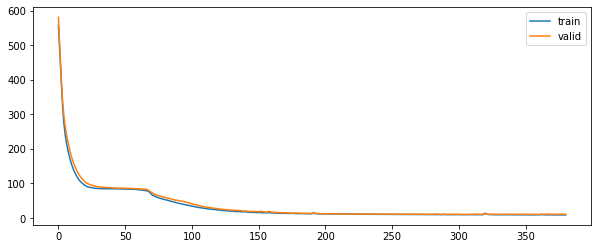

optimal epoch number: 306
params on optimal epoch:
mape on valid: 10.4012, on train: 11.2999
r2 on valid: 0.8342, on train: 0.8948
best val loss: 9.955119386131381
refit finished in 15.132886 sec
********************************************************************************
dropout rate: 0.1
--------------------------------------------------------------------------------
Epoch 00381: early stopping


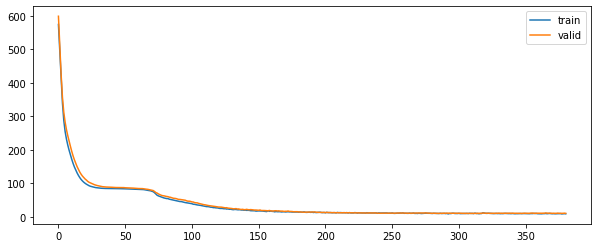

optimal epoch number: 306
params on optimal epoch:
mape on valid: 10.5532, on train: 11.8225
r2 on valid: 0.8402, on train: 0.8700
best val loss: 9.940963786325337
refit finished in 15.792637 sec
********************************************************************************
dropout rate: 0.2
--------------------------------------------------------------------------------
Epoch 00370: early stopping


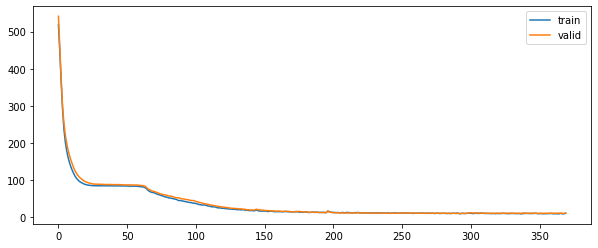

optimal epoch number: 295
params on optimal epoch:
mape on valid: 10.6784, on train: 11.9191
r2 on valid: 0.8395, on train: 0.8508
best val loss: 9.842335294794154
refit finished in 14.873248 sec
********************************************************************************
dropout rate: 0.3
--------------------------------------------------------------------------------
Epoch 00455: early stopping


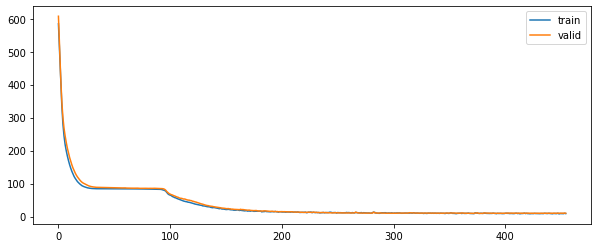

optimal epoch number: 380
params on optimal epoch:
mape on valid: 10.5707, on train: 11.6925
r2 on valid: 0.8394, on train: 0.8381
best val loss: 9.802790959676107
refit finished in 19.156681 sec
********************************************************************************


In [143]:
# 3.3.1. 1 слой dropout
dropout_rates = [0, 0.1, 0.2, 0.3]

for d in dropout_rates:
    x_in = Input(input_shape)
    x_1 = Dense(128, activation='linear')(x_in)
    x_d1 = Dropout(d)(x_1)
    x_2 = Dense(128, activation='sigmoid')(x_d1)
    x_out = Dense(1, activation='linear')(x_2)
    layers_seq = [x_in, x_1, x_d1, x_2, x_out] 

    print(f'dropout rate: {d}')
    print(80*'-')
    model = full_dense_regressor_compiler(layers_list=layers_seq, compile_params=comp_params, display_model=False,
                                         func_style=True)

    model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=32, validation_split=0.2, 
                          use_early_stopping=True, verbose_mode=0, show_chart=True)

    print(80*'*')
    

Особо dropout параметры не улучшает, поэтому на следующий этап модель будет без служебных слоев

##### Batch Size

batch size: 16
--------------------------------------------------------------------------------
Epoch 00276: early stopping


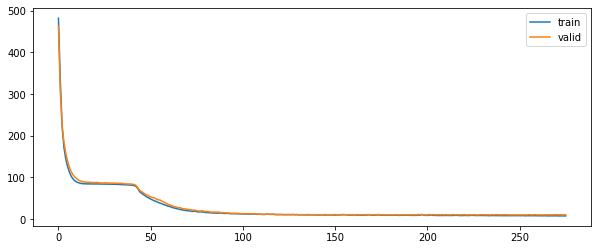

optimal epoch number: 201
params on optimal epoch:
mape on valid: 10.7388, on train: 11.3720
r2 on valid: -991748.9375, on train: 0.8449
best val loss: 9.952806484552077
refit finished in 20.418907 sec
********************************************************************************
batch size: 32
--------------------------------------------------------------------------------
Epoch 00478: early stopping


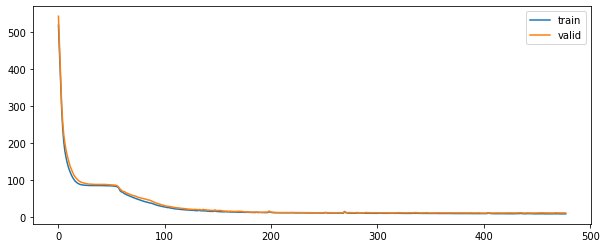

optimal epoch number: 403
params on optimal epoch:
mape on valid: 10.3764, on train: 10.7412
r2 on valid: 0.8437, on train: 0.8843
best val loss: 9.768123344138816
refit finished in 20.323647 sec
********************************************************************************
batch size: 64
--------------------------------------------------------------------------------


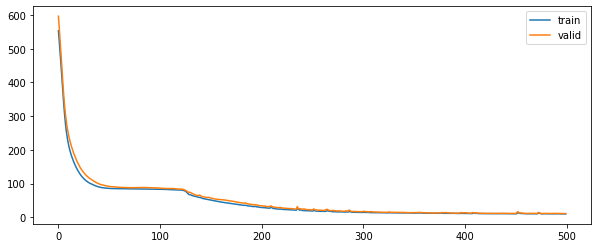

optimal epoch number: 500
params on optimal epoch:
mape on valid: 10.8230, on train: 11.9868
r2 on valid: 0.8722, on train: 0.8778
best val loss: 10.728568465621382
refit finished in 13.405339 sec
********************************************************************************
batch size: 256
--------------------------------------------------------------------------------


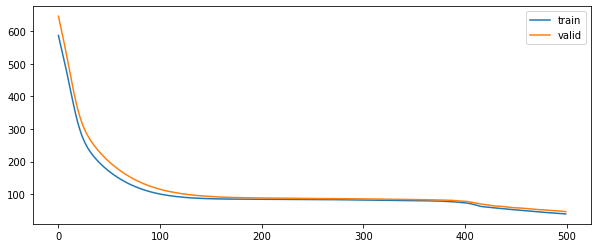

optimal epoch number: 500
params on optimal epoch:
mape on valid: 16.1800, on train: 17.2540
r2 on valid: 0.4520, on train: 0.5431
best val loss: 46.31439971923828
refit finished in 6.748067 sec
********************************************************************************


In [146]:
batch_sizes = [16, 32, 64, 256]

for bs in batch_sizes:
    x_in = Input(input_shape)
    x_1 = Dense(128, activation='linear')(x_in)
    x_2 = Dense(128, activation='sigmoid')(x_1)
    x_out = Dense(1, activation='linear')(x_2)
    layers_seq = [x_in, x_1, x_2, x_out] 

    print(f'batch size: {bs}')
    print(80*'-')
    model = full_dense_regressor_compiler(layers_list=layers_seq, compile_params=comp_params, display_model=False,
                                         func_style=True)

    model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=500, batch_size=bs, validation_split=0.2, 
                          use_early_stopping=True, verbose_mode=0, show_chart=True)

    print(80*'*')

##### Optimizer testing

optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000022D29EC07C8>
--------------------------------------------------------------------------------
Epoch 00832: early stopping


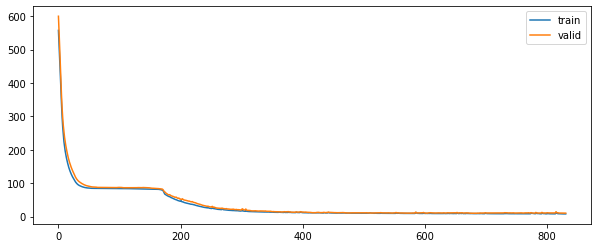

optimal epoch number: 682
params on optimal epoch:
mape on valid: 10.6167, on train: 10.9240
r2 on valid: 0.8716, on train: 0.9012
best val loss: 9.80116688174966
refit finished in 20.419857 sec
********************************************************************************
optimizer: <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x0000022D29EC0E88>
--------------------------------------------------------------------------------


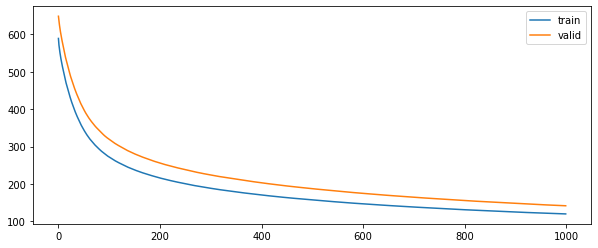

optimal epoch number: 1000
params on optimal epoch:
mape on valid: 31.6957, on train: 32.9973
r2 on valid: -0.5736, on train: -0.4896
best val loss: 141.98617059213143
refit finished in 21.060167 sec
********************************************************************************
optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000022D29EC0608>
--------------------------------------------------------------------------------
Epoch 00466: early stopping


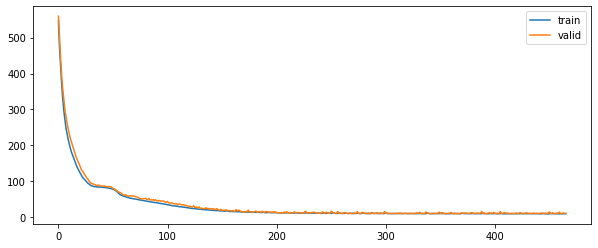

optimal epoch number: 316
params on optimal epoch:
mape on valid: 10.9770, on train: 11.5605
r2 on valid: 0.8740, on train: 0.8737
best val loss: 10.010191823229377
refit finished in 11.433847 sec
********************************************************************************
optimizer: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x0000022D29EC0D48>
--------------------------------------------------------------------------------
Epoch 00338: early stopping


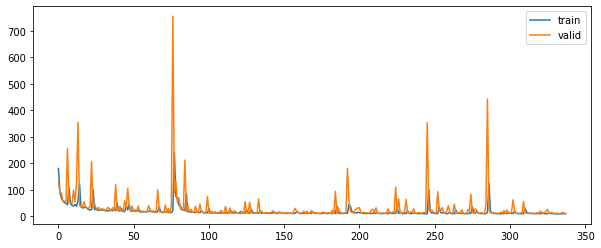

optimal epoch number: 188
params on optimal epoch:
mape on valid: 10.8563, on train: 15.2363
r2 on valid: 0.8643, on train: 0.7868
best val loss: 9.79573083218233
refit finished in 7.307316 sec
********************************************************************************


In [153]:
# 3.5.1. default params
comp_params_1 = {
    'loss': 'mse',
    'optimizer': Adam(),
    'metrics': ['mean_absolute_percentage_error', r2]
}

comp_params_2 = {
    'loss': 'mse',
    'optimizer': Adagrad(),
    'metrics': ['mean_absolute_percentage_error', r2]
}

comp_params_3 = {
    'loss': 'mse',
    'optimizer': RMSprop(),
    'metrics': ['mean_absolute_percentage_error', r2]
}

comp_params_4 = {
    'loss': 'mse',
    'optimizer': SGD(),
    'metrics': ['mean_absolute_percentage_error', r2]
}



optimizers = [comp_params_1, comp_params_2, comp_params_3, comp_params_4]

for params in optimizers:
    x_in = Input(input_shape)
    x_1 = Dense(128, activation='linear')(x_in)
    x_2 = Dense(128, activation='sigmoid')(x_1)
    x_out = Dense(1, activation='linear')(x_2)
    layers_seq = [x_in, x_1, x_2, x_out] 

    print(f'optimizer: {params["optimizer"]}')
    print(80*'-')
    model = full_dense_regressor_compiler(layers_list=layers_seq, compile_params=params, display_model=False,
                                         func_style=True)

    model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=1000, batch_size=64, validation_split=0.2, 
                          use_early_stopping=True, verbose_mode=0, show_chart=True)

    print(80*'*')

In [154]:
Adam()

lr: 0.01, epsilon: 1e-05
--------------------------------------------------------------------------------
Epoch 00413: early stopping


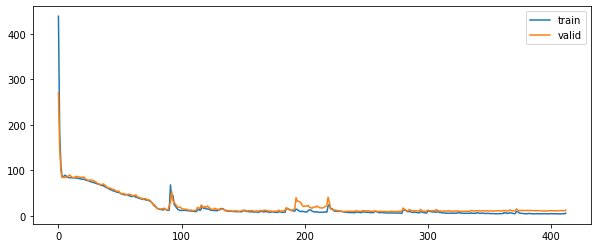

optimal epoch number: 263
params on optimal epoch:
mape on valid: 10.6982, on train: 10.0822
r2 on valid: 0.8897, on train: 0.9192
best val loss: 9.544947371070768
refit finished in 10.372934 sec
********************************************************************************
lr: 0.01, epsilon: 1e-07
--------------------------------------------------------------------------------
Epoch 00378: early stopping


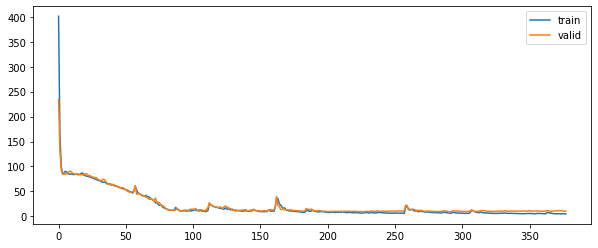

optimal epoch number: 228
params on optimal epoch:
mape on valid: 10.5729, on train: 9.8549
r2 on valid: 0.8668, on train: 0.8598
best val loss: 9.021904939486657
refit finished in 9.673115 sec
********************************************************************************
lr: 0.01, epsilon: 1e-09
--------------------------------------------------------------------------------
Epoch 00487: early stopping


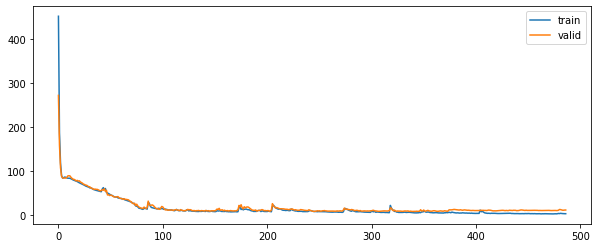

optimal epoch number: 337
params on optimal epoch:
mape on valid: 10.5315, on train: 10.0416
r2 on valid: 0.8747, on train: 0.9051
best val loss: 8.562031027711468
refit finished in 12.421569 sec
********************************************************************************
lr: 0.001, epsilon: 1e-05
--------------------------------------------------------------------------------
Epoch 00688: early stopping


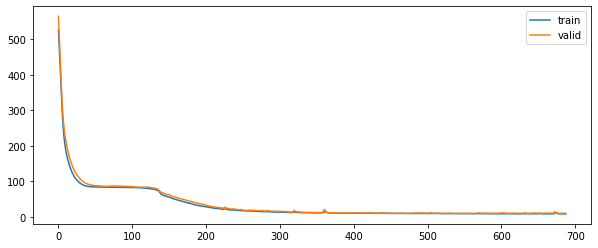

optimal epoch number: 538
params on optimal epoch:
mape on valid: 10.8015, on train: 11.3244
r2 on valid: 0.8716, on train: 0.8076
best val loss: 10.035288757748074
refit finished in 17.016571 sec
********************************************************************************
lr: 0.001, epsilon: 1e-07
--------------------------------------------------------------------------------


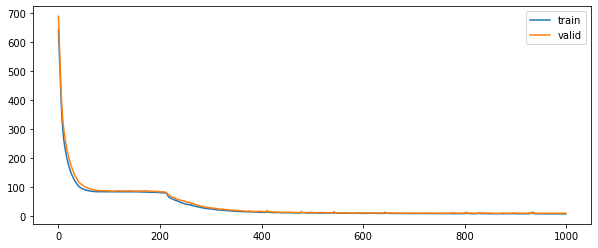

optimal epoch number: 859
params on optimal epoch:
mape on valid: 10.6957, on train: 11.4550
r2 on valid: 0.8767, on train: 0.9102
best val loss: 9.681022084789511
refit finished in 25.074459 sec
********************************************************************************
lr: 0.001, epsilon: 1e-09
--------------------------------------------------------------------------------
Epoch 00626: early stopping


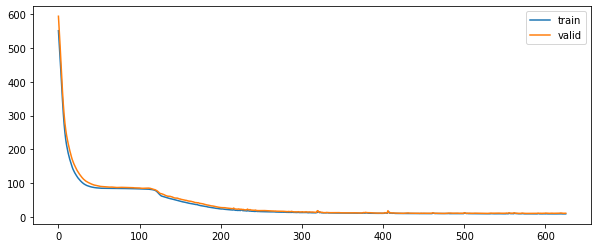

optimal epoch number: 476
params on optimal epoch:
mape on valid: 10.6459, on train: 12.1154
r2 on valid: 0.8814, on train: 0.8880
best val loss: 10.335160596871082
refit finished in 15.203158 sec
********************************************************************************
lr: 0.0001, epsilon: 1e-05
--------------------------------------------------------------------------------


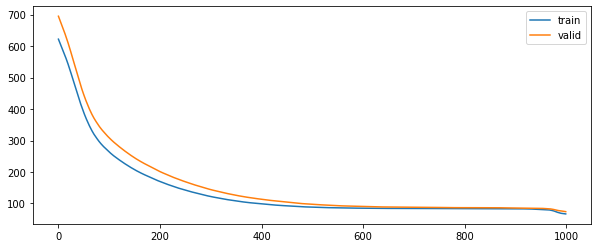

optimal epoch number: 1000
params on optimal epoch:
mape on valid: 20.1399, on train: 23.8648
r2 on valid: 0.3503, on train: -0.2768
best val loss: 74.09691411477549
refit finished in 24.647849 sec
********************************************************************************
lr: 0.0001, epsilon: 1e-07
--------------------------------------------------------------------------------


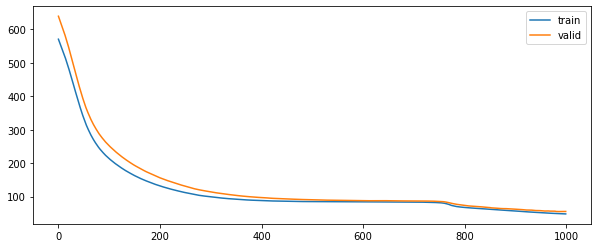

optimal epoch number: 988
params on optimal epoch:
mape on valid: 18.6238, on train: 20.4755
r2 on valid: 0.5044, on train: 0.4695
best val loss: 55.36943323818254
refit finished in 25.139965 sec
********************************************************************************
lr: 0.0001, epsilon: 1e-09
--------------------------------------------------------------------------------


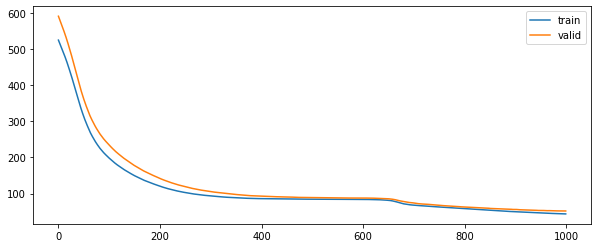

optimal epoch number: 996
params on optimal epoch:
mape on valid: 18.5586, on train: 19.2799
r2 on valid: 0.5103, on train: 0.4786
best val loss: 51.63256998415346
refit finished in 24.078539 sec
********************************************************************************


In [156]:
# 3.5.1. default params
lr_list = [0.01, 0.001, 0.0001]
epsilon_list = [1e-5, 1e-7, 1e-9]

grid = list(itertools.product(lr_list, epsilon_list))

for comb in grid:
    lr = comb[0]
    eps = comb[1]
    comp_params_ = {
                    'loss': 'mse',
                    'optimizer': Adam(learning_rate=lr, epsilon=eps),
                    'metrics': ['mean_absolute_percentage_error', r2]
                    }

    x_in = Input(input_shape)
    x_1 = Dense(128, activation='linear')(x_in)
    x_2 = Dense(128, activation='sigmoid')(x_1)
    x_out = Dense(1, activation='linear')(x_2)
    layers_seq = [x_in, x_1, x_2, x_out] 

    print(f'lr: {lr}, epsilon: {eps}')
    print(80*'-')
    model = full_dense_regressor_compiler(layers_list=layers_seq, compile_params=comp_params_, 
                                                          display_model=False, func_style=True)

    model = mlp_regr_fit_valid(model, X_train_nn, y_train, n_epochs=1000, batch_size=64, 
                                               validation_split=0.2, use_early_stopping=True, verbose_mode=0, 
                                               show_chart=True)

    print(80*'*')

Выводы по подбору параметров
- оптимальная архитектура: FC(128, linear) - FC(128, sigmoid) - FC(1, linear)
- размер батча: 64
- существенный прирост по метрике аккуратности достигнут был (с 50 до 85%)
- оптимальный оптимизатор - ADAM(lr=0.01, epsilon=1e-5)

#### Обучение финальной модели и валидация на тестовой выборке

In [162]:
comp_params_opt = {
                    'loss': 'mse',
                    'optimizer': Adam(learning_rate=0.01, epsilon=1e-5),
                    'metrics': ['mean_absolute_percentage_error', r2]
                    }

x_in = Input(input_shape)
x_1 = Dense(128, activation='linear')(x_in)
x_2 = Dense(128, activation='sigmoid')(x_1)
x_out = Dense(1, activation='linear')(x_2)
layers_opt = [x_in, x_1, x_2, x_out] 



model = full_dense_regressor_compiler(layers_list=layers_opt, compile_params=comp_params_opt, display_model=False,
                                     func_style=True)

predict = mlp_predict(model, X_train_nn, y_train, X_test_nn, y_test, n_epochs=450, batch_size=64, 
                      refit_model_on_full_data=True, verbose_refit=0)

refit on full train (99%) dataset activated
refit succeed in 11.6 sec

predict generated in 0.0 sec
r2 on test dataset: 0.8135
